In [1]:
import matplotlib as mpl

pt = 1 / 72
textwidth = 397.48499 * pt

mpl.rcParams.update(
    {
        "font.size": 9,
        "font.serif": [],
        "axes.titlesize": "medium",
        "legend.fontsize": "small",
        "legend.title_fontsize": "small",
        "figure.dpi": 200,
    }
)

# Feature geometry of RNNs under memory demands

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## $k$-delay data

In [3]:
from tqdm.notebook import tqdm


def sparse_tensor(size: tuple | torch.Size, sparsity: float) -> torch.Tensor:
    """
    Returns a tensor of the specified size whose elements are 0 with probability
    equal to sparsity, and distributed according to Uniform[0, 1) otherwise.
    """

    # Create a binary mask corresponding to active/inactive features. This
    # is the B_t ~ Bernoulli(p) part of the input.
    p = 1 - sparsity
    mask = torch.bernoulli(torch.full(size, p, device=device))

    # Generate the underlying data distribution and mask it to incorporate
    # sparsity. Here we use U_t ~ Uniform[0, 1), similar to Elhage, et al.,
    # "Toy Models of Superposition", 2022.
    return mask * torch.rand(size, device=device)


def sparse_k_delay_data(
    n_examples: int,
    *,
    n_features: int,
    n_timesteps: int,
    sparsity: float,
    ks: list[int],
    include_all_zeros: bool = False
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Returns n_examples of inputs and targets (X, Y) of k-delay data.

    Each input and target is a sequence of length n_timesteps; each element of
    the sequence contains n_features. The ith feature is delayed in the target
    by ks[i] timesteps. The inputs are generated with the given sparsity.
    """
    xs = []
    ys = []

    with tqdm(total=n_examples) as pbar:
        while len(xs) < n_examples:
            # Generate one input sequence x.
            x = sparse_tensor((n_features, n_timesteps), sparsity)

            # If it's all zero, we might want to skip it, e.g. when the model
            # has no bias terms (so the model output is guaranteed to be zero).
            if (x == 0).all() and not include_all_zeros:
                continue
            xs.append(x)

            # The corresponding output sequence y will have the same shape as x
            # but each feature will be delayed by a different amount. The
            # beginning of the sequence is appropriately padded with zeros.
            y = torch.zeros_like(x, device=device)
            for f, k in enumerate(ks):
                y[f, k:] = x[f, : n_timesteps - k]
            ys.append(y)

            pbar.update(1)

    X = torch.stack(xs)  # (n_examples, n_features, n_timesteps)
    Y = torch.stack(ys)  # (n_examples, n_features, n_timesteps)

    return X, Y


def make_impulse_xs(n_timesteps: int, n_features: int) -> torch.Tensor:
    """Create impulse response test data"""
    xs = torch.zeros(n_features, n_features, n_timesteps, device=device)
    for f in range(n_features):
        xs[f, f, 0] = 1.0
    return xs

## Model and training loop

In [4]:
from __future__ import annotations

from torch import nn
import torch.nn.functional as F


class BatchedRNN(nn.Module):
    def __init__(
        self,
        *,
        n_models: int = 1,
        n_neurons: int,
        n_features: int,
        nonlinear_y: bool = True,
        nonlinear_h: bool = True,
        tie_readouts: bool = False,
        ks: list[int] | None = None,
    ) -> None:
        """
        Represents multiple (n_models) RNNs.

        Each model has a hidden state of size n_neurons. The three architectures
        discussed in the paper can be constructed with the following settings:
         * Linear RNN: nonlinear_y = False, nonlinear_h = False
         * SSM: nonlinear_y = True, nonlinear_h = False
         * Nonlinear RNN: nonlinear_y = True, nonlinear_h = True

        By default, Wy (corresponding to the read-out vectors) are independently
        learnable parameters. However, for visual simplification, in the main
        content of the paper we often tie Wy := Wh^k Wx. This simply adapts the
        Wy := Wx trick from Elhage, et al., 2022 to the RNN k-delay setup. This
        mode is activated by setting tie_readouts=True and providing ks. All
        results still hold with Wy untied; this setting just helps to achieve
        visual clarity in the paper's figures.
        """
        super().__init__()

        self.n_models = n_models
        self.Nh = n_neurons
        self.Nx = n_features

        self.nonlinear_h = nonlinear_h
        self.nonlinear_y = nonlinear_y

        self.tie_readouts = tie_readouts
        self.ks = ks

        self.Wx = nn.Parameter(torch.empty(n_models, self.Nh, self.Nx))
        self.Wh = nn.Parameter(torch.empty(n_models, self.Nh, self.Nh))

        # If tie_readouts=False, this is the actual Wy that is used and trained.
        # If tie_readouts=True, this is unused and we define Wy := Wh^k Wx.
        self._Wy = nn.Parameter(torch.empty(n_models, self.Nh, self.Nx))

        for i in range(n_models):
            nn.init.xavier_normal_(self.Wx[i])
            nn.init.xavier_normal_(self.Wh[i])
            nn.init.xavier_normal_(self._Wy[i])

    @property
    def Wy(self) -> torch.Tensor:
        # If the readouts Wy are not tied to Wh^k Wx, just return the
        # trainable parameter _Wy.
        if not self.tie_readouts:
            return self._Wy

        # Otherwise, compute Wy := Wh^k Wx.
        Wy = torch.zeros(self.n_models, self.Nh, self.Nx, device=device)

        # Each feature might be delayed by a different amount, so we select the
        # corresponding Wx vector and apply the correct power of Wh to it.
        for f, k in enumerate(self.ks):
            Wy[:, :, f : f + 1] = torch.bmm(
                torch.matrix_power(self.Wh, k), self.Wx[:, :, f : f + 1]
            )

        return Wy

    def _forward_step(
        self, x: torch.Tensor, h_prev: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass for a single timestep.

        x: (n_models, batch_size, n_features)
        h_prev: (n_models, batch_size, n_neurons)
        """
        # Compute pre-activation hidden state h_t = Wx x_t + Wh ReLU(h_{t-1}).
        Wx_x = torch.bmm(self.Wx, x.transpose(-2, -1))
        h_prev = F.relu(h_prev) if self.nonlinear_h else h_prev
        Wh_h = torch.bmm(self.Wh, h_prev.transpose(-2, -1))
        h = Wx_x + Wh_h  # (n_models, n_neurons, batch_size)

        # Compute output: y_t = ReLU(Wy^T h_t)
        WyT_h = torch.bmm(self.Wy.transpose(-2, -1), h)

        # Transpose back to batch dimension
        WyT_h = WyT_h.transpose(-2, -1)  # (n_models, batch_size, n_features)
        h = h.transpose(-2, -1)  # (n_models, batch_size, n_neurons)

        # Compute and return the output y_pred and new hidden state h
        y_pred = F.relu(WyT_h) if self.nonlinear_y else WyT_h
        return y_pred, h

    def forward_sequence(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass over an entire sequence.

        x: (n_models, batch_size, n_features, n_timesteps) OR (batch_size, n_features, n_timesteps)
        """
        # If running as a single model (rather than n_models), expand dims.
        squeeze_output = False
        if x.dim() == 3 and self.n_models == 1:
            x = x.unsqueeze(0)
            squeeze_output = True

        n_models, batch_size, n_features, n_timesteps = x.shape

        # We start with an all-zero hidden state.
        h0 = torch.zeros(n_models, batch_size, self.Nh, device=x.device)

        ys = torch.zeros(n_models, batch_size, self.Nx, n_timesteps, device=x.device)
        hs = torch.zeros(
            n_models, batch_size, self.Nh, n_timesteps + 1, device=x.device
        )

        hs[:, :, :, 0] = h0  # (n_models, batch_size, n_neurons)
        h_curr = h0

        # Run through each input in the sequence, storing outputs and hs.
        for t in range(n_timesteps):
            x_t = x[:, :, :, t]  # (n_models, batch_size, n_features)
            y_t, h_curr = self._forward_step(x_t, h_curr)

            ys[:, :, :, t] = y_t
            hs[:, :, :, t + 1] = h_curr

        if squeeze_output:
            return ys.squeeze(0), hs.squeeze(0)
        return ys, hs

    def get_single_model(self, idx: int) -> BatchedRNN:
        """
        Extract out a single RNN by its index. Returns a BatchedRNN with
        n_models=1.
        """

        # Create a new BatchedRNN with the same configuration as this one except
        # with n_models=1.
        single_model = BatchedRNN(
            n_models=1,
            n_neurons=self.Nh,
            n_features=self.Nx,
            nonlinear_y=self.nonlinear_y,
            nonlinear_h=self.nonlinear_h,
            tie_readouts=self.tie_readouts,
            ks=self.ks,
        )

        # Initialise the new model with the weights of the selected model.
        single_model.Wx.data.copy_(self.Wx[idx : idx + 1])
        single_model.Wh.data.copy_(self.Wh[idx : idx + 1])
        single_model._Wy.data.copy_(self._Wy[idx : idx + 1])

        return single_model.to(device)


def train_batched_rnn(
    model: BatchedRNN,
    X: torch.Tensor,
    Y: torch.Tensor,
    *,
    n_batches: int = 1000,
    lr: float = 5e-3,
    importance_dropoff: float = 0.9,
) -> torch.Tensor:
    """
    Train multiple RNNs in parallel. Returns an EMA loss history for each model.
    """
    n_examples, n_features, n_timesteps = X.shape

    n_models = model.n_models
    batch_size = n_examples // n_batches

    # Feature importances: geometric e.g. A=1, B=0.9, C=0.9^2, D=0.9^3, E=0.9^4.
    importances = (
        (importance_dropoff ** torch.arange(n_features, device=device))
        .unsqueeze(-1)
        .expand(n_features, n_timesteps)
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # We keep track of an exponential moving average (EMA) of the training loss
    # of each model. In our work we aren't that interested in the actual value
    # of the loss, or train/validation/test performance - we're just interested
    # in studying the feature geometry of the "best" model, and EMA training
    # loss is good enough for that (overfitting is not an issue here because we
    # have an infinite supply of data from the distribution we want to model).
    loss_ema = []

    for batch_idx in tqdm(range(n_batches)):
        optimizer.zero_grad()

        # Get the batch of inputs and targets.
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        batch_X = X[start_idx:end_idx]
        batch_Y = Y[start_idx:end_idx]
        batch_size_actual = batch_X.shape[0]

        # Expand batch over all models: (batch, ...) -> (n_models, batch, ...).
        batch_X = batch_X.unsqueeze(0).expand(n_models, -1, -1, -1)
        batch_Y = batch_Y.unsqueeze(0).expand(n_models, -1, -1, -1)

        # Forward pass for all models and sequences in parallel.
        y_pred, _ = model.forward_sequence(batch_X)

        # Compute loss weighted by importance of each feature.
        mses = (batch_Y - y_pred) ** 2
        weighted_mses = mses * importances

        # Sum over batch, feature, timestep to get a total loss per model.
        loss = weighted_mses.reshape(n_models, -1).sum(dim=1)

        # Normalize to get each model's average loss over an entire sequence.
        loss_normalized = loss / (batch_size_actual * model.Nx)

        # Average across models for backprop.
        loss_normalized.mean().backward()

        optimizer.step()

        # Update EMA loss history.
        with torch.no_grad():
            if len(loss_ema) == 0:
                loss_ema.append(loss.detach())
            else:
                loss_ema.append(loss_ema[-1] + 0.01 * (loss.detach() - loss_ema[-1]))

    return loss_ema  # (n_batches, n_models)

## Plotting the hidden state

In [5]:
from matplotlib import pyplot as plt
from matplotlib import collections as mc
import numpy as np
from scipy.spatial import ConvexHull
from typing import Any


def plot_hidden_state(
    Wy: torch.Tensor,
    hs: torch.Tensor,
    k: int,
    n_test_timesteps: int,
    n_features: int,
    ax: Any,
    *,
    title: str | None = None,
    shade: bool = True,
    offset: float = 0.3,
    threshold: float = 0.2
) -> None:
    max_norm = torch.max(torch.norm(hs, dim=1))
    hs /= max_norm

    all_hs = torch.cat(torch.unbind(hs), dim=1).T
    hull = ConvexHull(all_hs)

    for f in range(n_features):
        if not any(p in hull.vertices for p in range(f * n_test_timesteps, (f + 1) * n_test_timesteps)):
            continue

        h_f = hs[f]
        hxs, hys = h_f

        colors = plt.get_cmap("hsv")(
            0.75 * torch.arange(0, n_test_timesteps) / (n_test_timesteps - 1)
        ) / [1, 1.5, 1, 1]
        s = torch.linalg.norm(h_f, dim=0)
        s = torch.where(s > threshold, s, 0)
        if f == 0:
            ax.scatter(hxs, hys, c=colors, s=torch.where(s > threshold, 20, 0))
        else:
            ax.scatter(hxs, hys, c=colors, s=torch.where(s > threshold, 30, 0), marker=(f + 2, 0, 0))

        ax.scatter(
            hxs + offset * hxs / s,
            hys + offset * hys / s,
            s=0,
        )
        for i, s_ in enumerate(s):
            ax.annotate(
                r"$\mathrm{" + f"{chr(ord('A') + f)}" + r"}$",
                xy=(hxs[i] + offset * hxs[i] / s_, hys[i] + offset * hys[i] / s_),
                c=colors[i],
                ha="center",
                va="center",
            )

        # Plot lines from origin to each point
        lines = mc.LineCollection(
            list(zip(np.zeros_like(h_f.T), torch.where(s[:, None] > 0, h_f.T, 0))),
            colors=colors,
            linewidth=1,
        )
        ax.add_collection(lines)

    ax.set_aspect("equal")
    ax.set_box_aspect(1)

    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()

    im = None
    if shade:
        Wy = Wy.numpy()
        # Define the grid for the heatmap
        x_range = np.linspace(minx - 1, maxx + 1, 2000)
        y_range = np.linspace(miny - 1, maxy + 1, 2000)
        X, Y = np.meshgrid(x_range, y_range)

        # Create array of all points in the grid
        # Shape: (2, 100*100) where each column is a 2D point
        points = np.vstack([X.ravel(), Y.ravel()])

        projections = np.maximum(points.T @ Wy, 0)

        # Sum projections for each point
        projection_sums = np.sum(projections, axis=1)

        # Reshape back to grid shape
        Z = projection_sums.reshape(X.shape)

        # Create the heatmap
        im = ax.imshow(Z, extent=[x_range[0], x_range[-1], y_range[0], y_range[-1]],
            origin='lower', cmap="PuBu_r", aspect='equal', zorder=-1, vmax=1, rasterized=True)

    ax.set_xlim(minx - 0.1, maxx + 0.1)
    ax.set_ylim(miny - 0.1, maxy + 0.1)
    ax.axvline(0, c="gray", ls="--", lw=0.75, alpha=0.25, zorder=-1)
    ax.axhline(0, c="gray", ls="--", lw=0.75, alpha=0.25, zorder=-1)
    ax.set_xticks([])
    ax.set_yticks([])
    for sp in ax.spines:
        ax.spines[sp].set_linewidth(0.5)

    if title is not None:
        ax.set_title(title, y=-0.25)

    return im

## Figures 1 and 4

In [6]:
n_features = 5
sparsity = 0.99
importance_dropoff = 0.99

n_models = 100
n_neurons = 2
nonlinear_h = True
nonlinear_y = True

n_examples = 10_000
n_timesteps = 10
lr = 5e-3

for k in range(6):
    ks = [k] * n_features
    print(f"Task     | {n_features=}, {ks=}, {sparsity=}, {importance_dropoff=}")
    print(f"Models   | {n_models=}, {n_neurons=}, {nonlinear_y=}, {nonlinear_h=}")
    print(f"Training | {n_examples=}, {n_timesteps=}, {lr=}")

    # Create a training dataset.
    train_X, train_Y = sparse_k_delay_data(
        n_examples,
        n_features=n_features,
        n_timesteps=n_timesteps,
        ks=ks,
        sparsity=sparsity,
    )

    # Create a batch of n_models RNNs to be trained in parallel.
    candidate_models = BatchedRNN(
        n_models=n_models,
        n_neurons=n_neurons,
        n_features=n_features,
        nonlinear_y=nonlinear_y,
        nonlinear_h=nonlinear_h,
        tie_readouts=True,
        ks=ks,
    ).to(device)

    # Train the models and get their EMA loss history.
    loss_ema_curves = train_batched_rnn(
        candidate_models, train_X, train_Y, lr=lr, importance_dropoff=importance_dropoff
    )

    # The best model has the lowest final loss.
    final_losses = loss_ema_curves[-1]
    best_model_idx = torch.argmin(final_losses)
    best_model = candidate_models.get_single_model(best_model_idx)

    n_test_timesteps = (k + 1) * 2
    test_xs = make_impulse_xs(n_test_timesteps, n_features)

    ys_list = []
    hs_list = []

    with torch.no_grad():
        for f in range(n_features):
            x = test_xs[f : f + 1]  # (1, n_features, n_test_timesteps)
            y, h = best_model.forward_sequence(x)

            ys_list.append(y[0])  # (n_features, n_test_timesteps)
            hs_list.append(h[0, :, 1:])  # (n_neurons, n_test_timesteps), skip h0

    # Concatenate along time dimension
    ys = torch.stack(ys_list).cpu()
    hs = torch.stack(hs_list).cpu()

    Wx = best_model.Wx.squeeze().detach().cpu()
    Wy = best_model.Wy[0].detach().cpu()

    torch.save(Wy, f"{n_features=}_{k=}_Wy.pt")
    torch.save(hs, f"{n_features=}_{k=}_hs.pt")

Task     | n_features=5, ks=[0, 0, 0, 0, 0], sparsity=0.99, importance_dropoff=0.99
Models   | n_models=100, n_neurons=2, nonlinear_y=True, nonlinear_h=True
Training | n_examples=10000, n_timesteps=10, lr=0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Task     | n_features=5, ks=[1, 1, 1, 1, 1], sparsity=0.99, importance_dropoff=0.99
Models   | n_models=100, n_neurons=2, nonlinear_y=True, nonlinear_h=True
Training | n_examples=10000, n_timesteps=10, lr=0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Task     | n_features=5, ks=[2, 2, 2, 2, 2], sparsity=0.99, importance_dropoff=0.99
Models   | n_models=100, n_neurons=2, nonlinear_y=True, nonlinear_h=True
Training | n_examples=10000, n_timesteps=10, lr=0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Task     | n_features=5, ks=[3, 3, 3, 3, 3], sparsity=0.99, importance_dropoff=0.99
Models   | n_models=100, n_neurons=2, nonlinear_y=True, nonlinear_h=True
Training | n_examples=10000, n_timesteps=10, lr=0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Task     | n_features=5, ks=[4, 4, 4, 4, 4], sparsity=0.99, importance_dropoff=0.99
Models   | n_models=100, n_neurons=2, nonlinear_y=True, nonlinear_h=True
Training | n_examples=10000, n_timesteps=10, lr=0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Task     | n_features=5, ks=[5, 5, 5, 5, 5], sparsity=0.99, importance_dropoff=0.99
Models   | n_models=100, n_neurons=2, nonlinear_y=True, nonlinear_h=True
Training | n_examples=10000, n_timesteps=10, lr=0.005


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

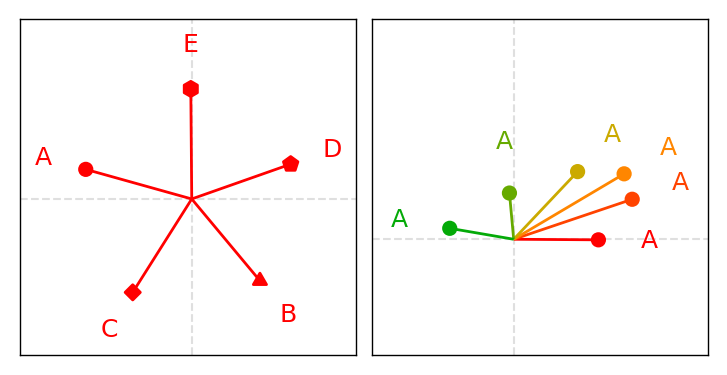

In [11]:
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(0.638 * textwidth, 0.319 * textwidth))

for k, ax in zip([0, 5], axs):
    Wy = torch.load(f"{n_features=}_{k=}_Wy.pt")
    hs = torch.load(f"{n_features=}_{k=}_hs.pt")

    hm = plot_hidden_state(Wy, hs, k, (k + 1) * 2, 5, ax, shade=False, offset=0.4)

plt.show()

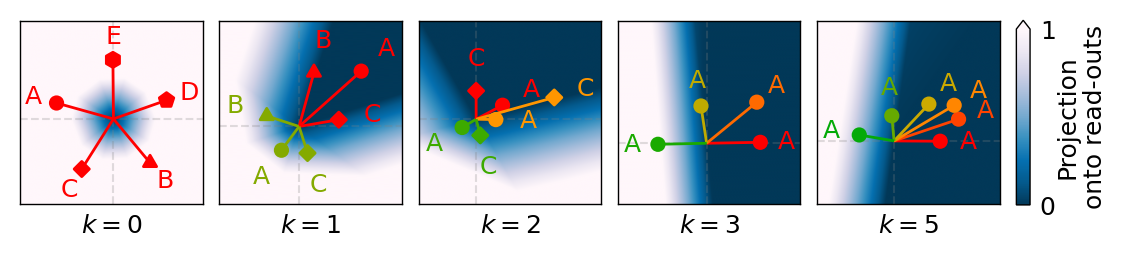

In [7]:
fig, axs = plt.subplots(
    1,
    6,
    figsize=(textwidth, 0.22 * textwidth),
    gridspec_kw={"width_ratios": [1, 1, 1, 1, 1, 0.075]},
    layout="constrained"
)

for k, ax in zip([0, 1, 2, 3, 5], axs[:5]):
    Wy = torch.load(f"{n_features=}_{k=}_Wy.pt")
    hs = torch.load(f"{n_features=}_{k=}_hs.pt")

    hm = plot_hidden_state(Wy, hs, k, (k + 1) * 2, 5, ax, shade=True, offset=0.4, title=fr"$k = {k}$")

cbar = fig.colorbar(hm, cax=axs[5], extend="max")
cbar.set_label("Projection\nonto read-outs", labelpad=0, fontsize=9)
cbar.ax.set_yticks([0, 1])
cbar.ax.tick_params(length=0, labelsize=9)
cbar.ax.set_title(" ", y=-0.3)
cbar.outline.set_linewidth(0.5)

plt.show()